In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import os
os.environ["TERRA_CONFIG_PATH"] = "/home/sabri/code/spr-21/terra_config.json"

import terra 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
from mosaic import DataPanel, NumpyArrayColumn

FileNotFoundError: [Errno 2] No such file or directory: '/home/sabri/code/spr-21/terra_config.json'

### Load `DataPanel` with CelebA validation data.

In [2]:
# Load Celeb DataPanel
from spr.data.celeb import build_celeb_df, get_celeb_dp
celeb_df = build_celeb_df.out(141, load=True)
celeb_dp = get_celeb_dp(celeb_df[celeb_df["split"] == "valid"])

### Solicit feedback from user.

In [3]:
from spr.feedback import solicit_feedback_imgs

solicit_feedback_imgs(
    celeb_dp,
    num_examples=500,
    img_column="img",
    label_column="smiling",
    #rank_by="feedback_preds_max",
    size=(256, 256)
)

Running locally at: http://127.0.0.1:7860/
To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7860/', None)

In [5]:
@terra.Task.make_task
def save_feedback(label, run_dir=None):
    feedback_dp = celeb_dp.filter(
        lambda x: x["feedback_label"] != "unlabeled",
        input_columns=["feedback_label"]
    )
    feedback_dp["img"]._materialize = False
    return feedback_dp[:], label

### Inspect feedback.

In [6]:
###### LOAD ######
feedback_dp = save_feedback.out(282)[0].load()

In [7]:
feedback_dp[["feedback_label", "feedback_pos_mask", "img_path"]]

DataPanel(num_rows: 10)

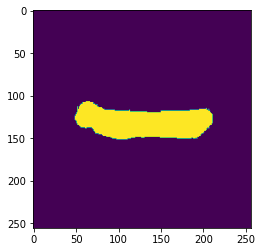

In [9]:
plt.imshow(feedback_dp["feedback_pos_mask"][2])

### Train a logistic regression model on scribbles.

In [11]:
# Load a full model trained on a different task
act_target = "heavy_makeup"
dp = terra.get_artifacts(
    run_id=327, group_name=f"{act_target}_activations"
)["dp"].load()

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import normalize
celeb_scribble = __import__("05-10_celeb_scribble")

threshold = 0.2

dp = celeb_scribble.merge_in_feedback(dp, feedback_dp)
feedback_dp = dp[np.where(dp["feedback_label"].data != "unlabeled")[0]]

print(f"Pooling masks for {len(feedback_dp)} examples...")
pooled_masks = {  
    f"{feedback_mask}_pool": nn.functional.avg_pool2d(
        input=feedback_dp[feedback_mask].to_tensor().to(float), kernel_size=(32,32)
    ).numpy()
    for feedback_mask in ["feedback_neg_mask", "feedback_pos_mask"]
}
x = feedback_dp["activation"].transpose(0, 2, 3, 1).reshape(-1, 512)
y = pooled_masks["feedback_pos_mask_pool"].flatten() > threshold

print("Fitting...")
lr = LogisticRegression()
x = normalize(x)
lr = lr.fit(x, y)

Pooling masks for 10 examples...
Fitting...


In [19]:
from sklearn.metrics import roc_auc_score

x_test = dp["activation"].transpose(0, 2, 3, 1).reshape(-1, 512)
x_test = normalize(x_test)
y_test_preds = lr.predict_proba(x_test)
dp.add_column(
    "feedback_preds", y_test_preds[:, 1].reshape(-1, 8, 8), overwrite=True
)
dp.add_column(
    "feedback_preds_max", dp["feedback_preds"].max(axis=(1,2)), overwrite=True
)
roc_auc_score(dp["eyeglasses"], dp["feedback_preds_max"])

0.9419561575995922

<ipython-input-21-654c75658e99>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axes = plt.subplots(1, 2)


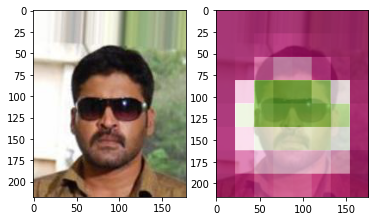

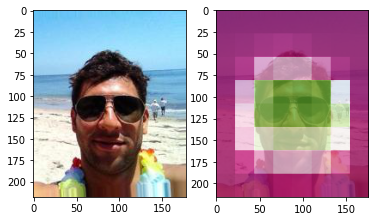

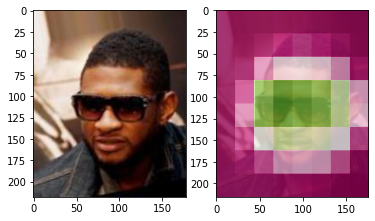

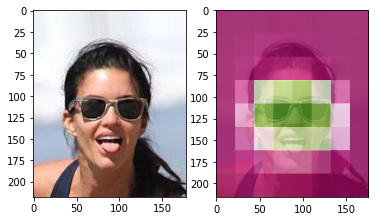

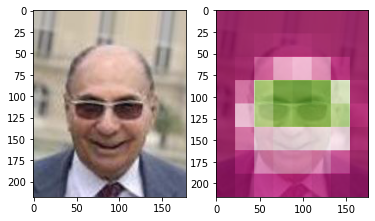

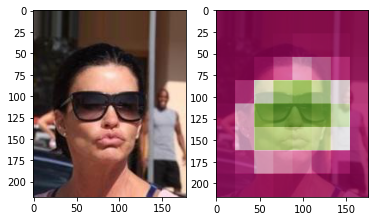

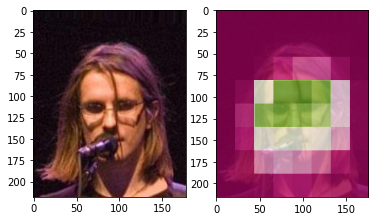

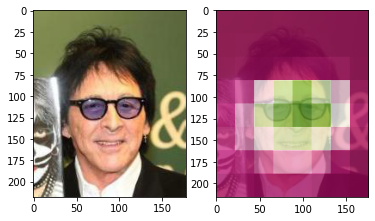

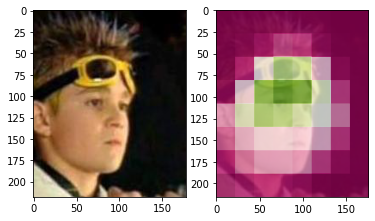

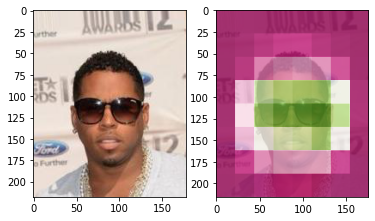

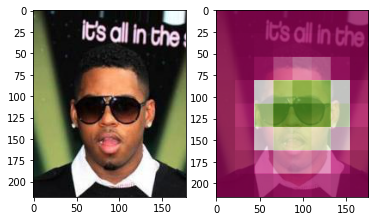

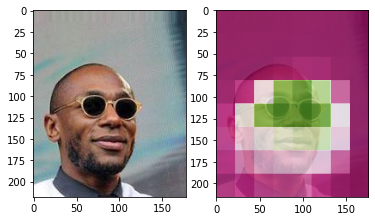

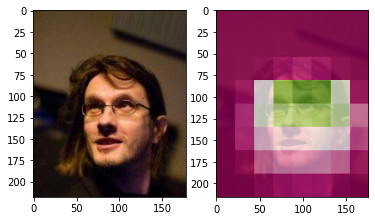

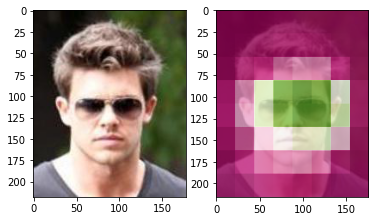

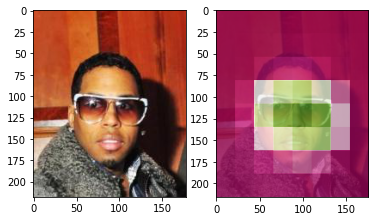

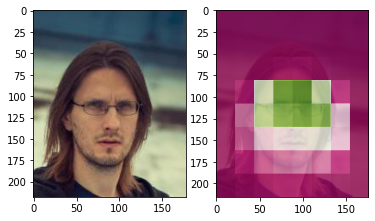

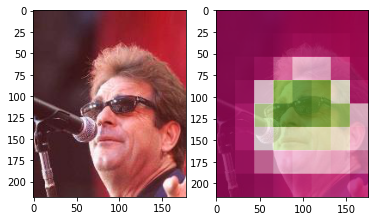

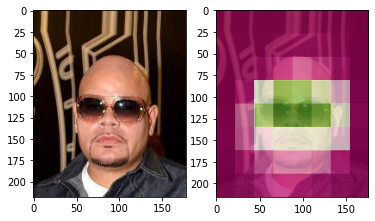

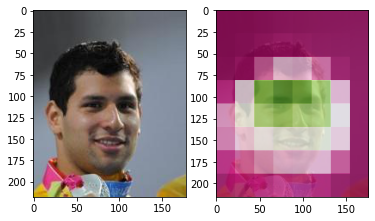

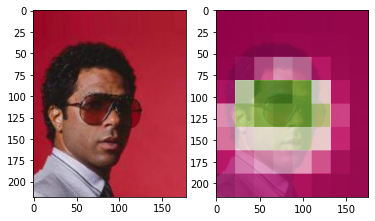

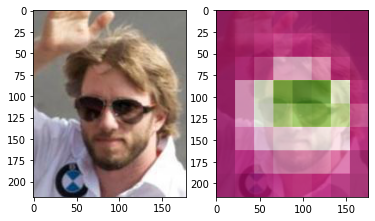

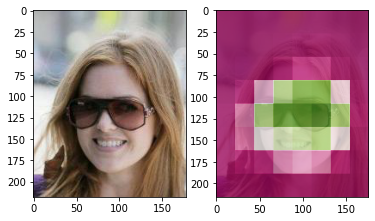

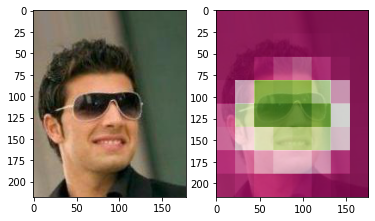

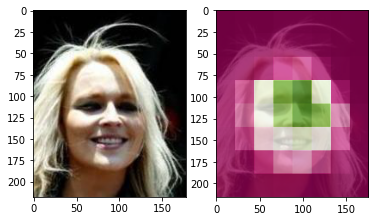

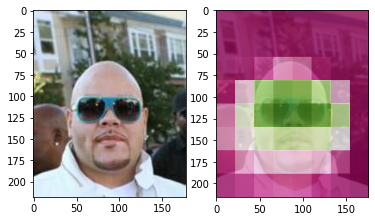

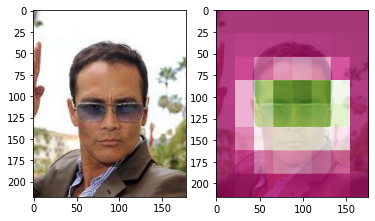

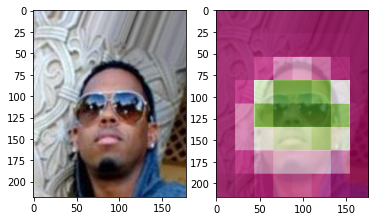

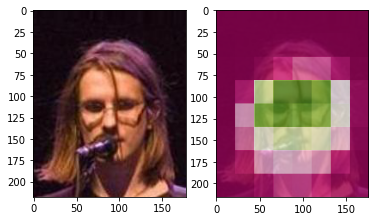

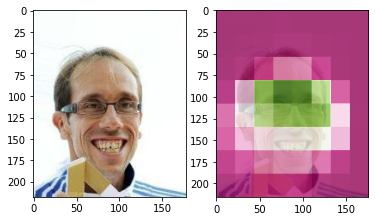

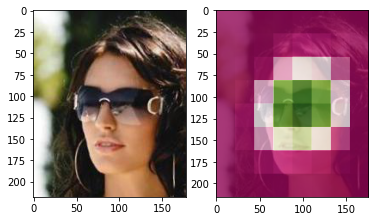

In [21]:
df = pd.DataFrame({
    column: dp[column].data
    for column in ["feedback_preds_max", "index"]
})
df = df.sort_values("feedback_preds_max")

global_min = dp["feedback_preds"].min()
global_max = dp["feedback_preds"].max()
for row in dp[np.array(df.index[-30:])]:
   _, axes = plt.subplots(1, 2)
   inp = np.array(row["img"])
   axes[0].imshow(inp)
   axes[1].imshow(inp)
   
   preds = np.array(row["feedback_preds"])
   preds = preds.repeat(
       inp.shape[0] / preds.shape[0], axis=0
   ).repeat(inp.shape[1] / preds.shape[1], axis=1)
   axes[1].imshow(
       preds,
       alpha=0.79, 
       cmap="PiYG",
       vmin=global_min,
       vmax=global_max
   )